In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import pandas as pd  
%matplotlib inline

In [2]:
train_house = pd.read_csv('D:/Datasets/House//train.csv') 

In [3]:
def RMSLE(y, y_pred):
        return np.sqrt(mean_squared_log_error(y, y_pred))

In [4]:
def calculate_correlation(column_1, column_2):
    print(f'Корреляция между {column_1.name} и {column_2.name} = {column_1.corr(column_2)}' )

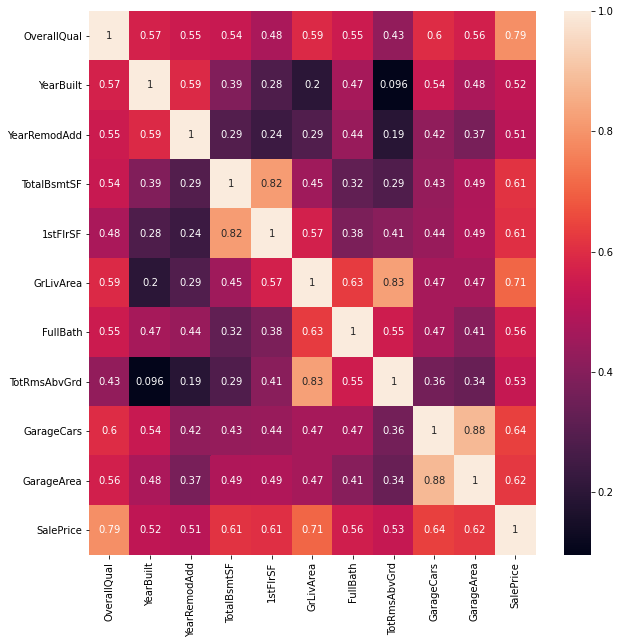

In [5]:
corrmat = train_house.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train_house[top_corr_features].corr(),annot = True)

Find correlated variables, remove one of them

In [6]:
d = list(map(calculate_correlation, *zip( \
                               (train_house['GarageArea'], train_house['GarageCars']),\
                               (train_house['YearBuilt'], train_house['GarageYrBlt']), \
                               (train_house['TotRmsAbvGrd'], train_house['GrLivArea']), \
                               (train_house['TotalBsmtSF'], train_house['1stFlrSF']))))

Корреляция между GarageArea и GarageCars = 0.8824754142814628
Корреляция между YearBuilt и GarageYrBlt = 0.825667484174342
Корреляция между TotRmsAbvGrd и GrLivArea = 0.8254893743088428
Корреляция между TotalBsmtSF и 1stFlrSF = 0.8195299750050333


Since there are columns that strongly correlate, we can delete one

In [7]:
train_house = train_house.drop(columns = ['GarageArea'])
train_house = train_house.drop(columns = ['GarageYrBlt'])
train_house = train_house.drop(columns = ['TotRmsAbvGrd'])
train_house = train_house.drop(columns = ['1stFlrSF'])

<AxesSubplot:>

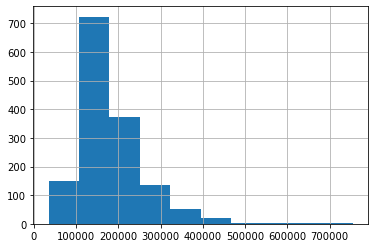

In [8]:
train_house.SalePrice.hist()

It is necessary to clean up large values in SalePrice, otherwise we will get "Mean Squared Logarithmic Error cannot be used when targets contain negative values.", because one of the values of y_pred < 0. This problem can be solved by data normalization, but then RMSLE = 0.27.

In [9]:
#? Можем ли мы производить манипуляции с этой колонкой?
g = train_house.SalePrice.quantile(0.9)
train_house.drop(train_house[train_house.SalePrice > g].index, inplace = True)
train_house['SalePrice'].apply(np.log)

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1315, dtype: float64

Find out how many missing values are in the data

In [10]:
total = train_house.isnull().sum().sort_values(ascending = False)
total.head(20)

PoolQC          1309
MiscFeature     1261
Alley           1224
Fence           1041
FireplaceQu      685
LotFrontage      246
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      37
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrType         7
MasVnrArea         7
Electrical         1
KitchenAbvGr       0
Functional         0
dtype: int64

*'MasVnrType', 'MasVnrArea', 'Electrical'* we don't fill in '0', because there are very few rows with missing values in these columns, it is better to delete.


*'MiscFeature'* we don't fill in '0', since there are really a lot of missing values.


*'LotFrontage'* we don't fill in '0' because in the other columns NaN = this is not in the house. And here NaN is the missing value. But there are a lot of them, it is better not to delete them, but to fill them with a median.

In [11]:
columns_with_nan = list(train_house.columns[train_house.isnull().any()])
unnecessary_values = ['MasVnrType', 'MasVnrArea', 'Electrical', 'MiscFeature', 'LotFrontage']
for value in unnecessary_values:
    columns_with_nan.remove(value)

In [12]:
def fill_in_missing_values(datdaframe, columns_with_nan):
    for column in columns_with_nan:
        datdaframe[column] = datdaframe[column].fillna('0')
fill_in_missing_values(train_house, columns_with_nan)

In [13]:
train_house = train_house.drop(columns = ['MiscFeature'])      

In [14]:
median_LF = train_house.LotFrontage.median()
train_house['LotFrontage'] = train_house['LotFrontage'].fillna(median_LF)

In [15]:
train_house = train_house.dropna(subset = ['MasVnrType', 'MasVnrArea', 'Electrical'], how='any')

In the columns *'LotFrontage', 'MasVnrArea'* all values end in '.0', so we won't lose anything if we convert the columns to int.

In [16]:
train_house.select_dtypes(include = ['float64'])

,LotFrontage,MasVnrArea
0,65.0,196.0
1,80.0,0.0
2,68.0,162.0
3,60.0,0.0
4,84.0,350.0
...,...,...
1455,62.0,0.0
1456,85.0,119.0
1457,66.0,0.0
1458,68.0,0.0


In [17]:
train_house.LotFrontage = pd.to_numeric(train_house.LotFrontage, downcast = 'integer')
train_house.MasVnrArea = pd.to_numeric(train_house.MasVnrArea, downcast = 'integer')

In [18]:
columns_with_object = list(train_house.select_dtypes(include = ['object']).columns)
columns_with_int = list(train_house.select_dtypes(include = ['int64']).columns)
columns_with_int.remove('SalePrice')

In [19]:
columns_to_encode = columns_with_object
columns_to_scale = columns_with_int

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), columns_to_encode),
    ('scaling', StandardScaler(), columns_to_scale)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegression())
])

X = train_house.drop(columns = ['SalePrice'])
y = train_house['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

pipe = pipeline.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"Test RMSE = {RMSLE(y_test, y_pred)}")

Test RMSE = 0.19190622715506325


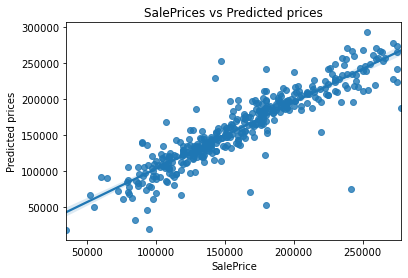

In [20]:
plt.ylabel("Predicted prices")
plt.title("SalePrices vs Predicted prices")

sns.regplot(x = y_test, y = y_pred, data = train_house)
plt.show()